In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import akshare as ak
from datetime import date, timedelta
from financial_calculator import *
from fundresearch import *
import seaborn as sns

from fund_tools import *
from AIP import *

![jupyter](./framework.png)

In [2]:
# Set date variable

today = date.today()
first_day_of_the_week = today - timedelta(days=today.weekday())
# end = start + timedelta(days=6)
print("Today: " + str(today))
print("Start: " + str(first_day_of_the_week))
# print("End: " + str(end))

Today: 2022-01-23
Start: 2022-01-17


In [3]:
stock_zh_index_spot_df = ak.stock_zh_index_spot()[['代码','名称']]
stock_zh_index_spot_df

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


,代码,名称
0,sh000001,上证指数
1,sh000002,Ａ股指数
2,sh000003,Ｂ股指数
3,sh000004,工业指数
4,sh000005,商业指数
...,...,...
583,sz988006,
584,sz988007,
585,sz988106,
586,sz988107,


- 中欧量化驱动基准指数：$创业板指数收益率 \times 95\% + 中债综合指数收益率 \times 5\%$
- 没有找到中债综合指数，暂用沪深300

In [4]:
stock_zh_index_spot_df[(stock_zh_index_spot_df['名称'] == '沪深300')|(stock_zh_index_spot_df['名称'] == '创业板指')]

,代码,名称
144,sh000300,沪深300
237,sz399006,创业板指
299,sz399300,沪深300


In [5]:
start_date = pd.to_datetime('2018-05-16')
end_date = pd.to_datetime(date.today())

HS300_index = ak.stock_zh_index_daily(symbol="sh000300")[['date', 'close']]
CY_index = ak.stock_zh_index_daily(symbol="sz399006")[['date', 'close']]

fund_value = get_fund_net_worth('001980', start_date=start_date, end_date=end_date, fund_category='open')


100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


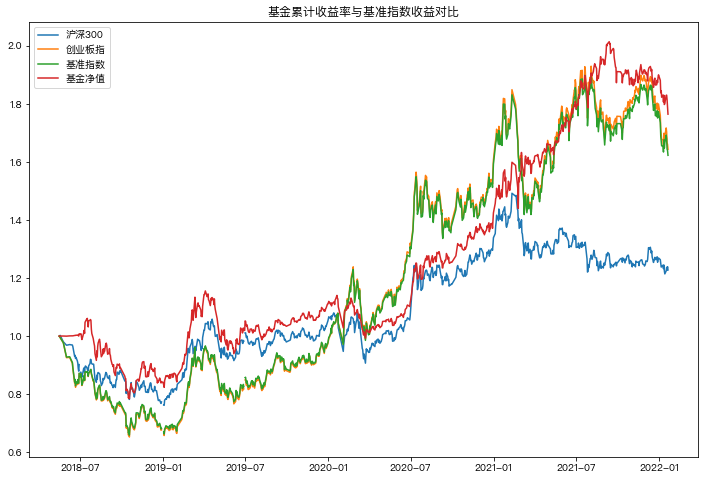

In [6]:
comp_df = fund_vs_benchmark('001980', ['sh000300', 'sz399006'], '2018-05-16', end_date, PLOT=True)

In [7]:
fund_value = fund_value.reset_index()

fund_value['year'] = pd.DatetimeIndex(fund_value['净值日期']).year
fund_value['month'] = pd.DatetimeIndex(fund_value['净值日期']).month
fund_value

,index,净值日期,单位净值,日增长率,year,month
0,0,2018-05-16,1.0000,0.00,2018,5
1,1,2018-05-18,1.0002,0.00,2018,5
2,2,2018-05-25,1.0003,0.00,2018,5
3,3,2018-06-01,0.9999,0.00,2018,6
4,4,2018-06-08,1.0008,0.00,2018,6
...,...,...,...,...,...,...
882,882,2022-01-17,1.8288,1.50,2022,1
883,883,2022-01-18,1.8300,0.07,2022,1
884,884,2022-01-19,1.8140,-0.87,2022,1
885,885,2022-01-20,1.7867,-1.50,2022,1


In [20]:
year_list = fund_value['year'].unique()

performance_df = pd.DataFrame()
for year in year_list:
    sub_df = fund_value[fund_value['year'] == year]

    metrics_list = [return_metrics(sub_df)[0], return_metrics(sub_df)[1], risk_metrics(sub_df)[0],
                    risk_metrics(sub_df)[1], sharpe(sub_df), calmar(sub_df)]

    performance_df[year] = metrics_list

performance_df['全区间'] = [return_metrics(fund_value)[0], return_metrics(fund_value)[1], risk_metrics(fund_value)[0],
                    risk_metrics(fund_value)[1], sharpe(fund_value), calmar(fund_value)]

performance_df.index = ['Absolute Return', 'Annulized Return', 'Annual Volatility',
                         'Max Drawdown', 'Sharpe Ratio', 'Calmar Ratio']

performance_df = performance_df.transpose()
performance_df


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


,Absolute Return,Annulized Return,Annual Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio
2018,-0.158200,-0.263331,24.440238,-0.260792,-1.124232,1.009738
2019,0.334134,0.345168,21.898399,-0.187089,1.030550,-1.844943
2020,0.272240,0.283636,17.441925,-0.128925,1.121712,-2.200015
2021,0.303933,0.316813,20.263625,-0.099650,1.176091,-3.179264
2022,-0.061995,-0.683995,18.368264,-0.061995,-1.771362,11.033090
全区间,0.764200,0.175020,20.749299,-0.260792,0.939585,-0.671109


In [43]:
# comp_df.reset_index(inplace=True)
HS300_df = comp_df[['净值日期','sh000300']]
CYZH_df = comp_df[['净值日期', 'sz399006']]
JZZH_df = comp_df[['净值日期', '基准指数']]

HS300_df.columns = ['净值日期', '单位净值']
CYZH_df.columns = ['净值日期', '单位净值']
JZZH_df.columns = ['净值日期', '单位净值']

HS300_df = daily_return(HS300_df)
CYZH_df = daily_return(CYZH_df)
JZZH_df = daily_return(JZZH_df)

In [44]:
comp_stat_df = pd.DataFrame()

comp_stat_df['中欧量化'] = [return_metrics(fund_value)[0], return_metrics(fund_value)[1], risk_metrics(fund_value)[0],
                    risk_metrics(fund_value)[1], sharpe(fund_value), calmar(fund_value)]
comp_stat_df['沪深300'] = [return_metrics(HS300_df)[0], return_metrics(HS300_df)[1], risk_metrics(HS300_df)[0],
                    risk_metrics(HS300_df)[1], sharpe(HS300_df), calmar(HS300_df)]
comp_stat_df['创业板指'] = [return_metrics(CYZH_df)[0], return_metrics(CYZH_df)[1], risk_metrics(CYZH_df)[0],
                    risk_metrics(CYZH_df)[1], sharpe(CYZH_df), calmar(CYZH_df)]
comp_stat_df['基准指数'] = [return_metrics(JZZH_df)[0], return_metrics(JZZH_df)[1], risk_metrics(JZZH_df)[0],
                    risk_metrics(JZZH_df)[1], sharpe(JZZH_df), calmar(JZZH_df)]

comp_stat_df.index = ['Absolute Return', 'Annulized Return', 'Annual Volatility',
                         'Max Drawdown', 'Sharpe Ratio', 'Calmar Ratio']

comp_stat_df = comp_stat_df.transpose()
comp_stat_df

100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


,Absolute Return,Annulized Return,Annual Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio
中欧量化,0.764200,0.175020,20.749299,-0.260792,0.939585,-0.671109
沪深300,0.227718,0.060018,20.836288,-0.240381,0.086218,-0.249679
创业板指,0.643321,0.151562,28.436797,-0.347459,0.737947,-0.436202
基准指数,0.622540,0.147407,27.960181,-0.340984,0.715899,-0.432298


In [50]:
comp_df = comp_df.drop(['level_0', 'index'], axis=1)
comp_df

,净值日期,单位净值,日增长率,sh000300,sz399006,基准指数
0,2018-05-16,1.0000,0.00,1.000000,1.000000,1.000000
1,2018-05-18,1.0002,0.00,1.002625,0.994628,0.995028
2,2018-05-25,1.0003,0.00,0.980388,0.977188,0.977348
3,2018-06-01,0.9999,0.00,0.968595,0.925744,0.927886
4,2018-06-08,1.0008,0.00,0.970914,0.926813,0.929018
...,...,...,...,...,...,...
882,2022-01-17,1.8288,1.50,1.224625,1.716820,1.692210
883,2022-01-18,1.8300,0.07,1.236460,1.702700,1.679388
884,2022-01-19,1.8140,-0.87,1.227991,1.665684,1.643799
885,2022-01-20,1.7867,-1.50,1.239071,1.660278,1.639218


In [69]:
## make three time slots

time_slots = pd.to_datetime(['2021-01-21', '2020-01-21', '2019-01-21'])
columns = ['近一年', '近两年', '近三年']
df_list = [comp_df, JZZH_df, HS300_df, CYZH_df]

return_df = pd.DataFrame(index=['中欧量化','基准指数','沪深300','创业板指'])

for i in range(len(time_slots)):
    annualreturn = []
    for df in df_list:
        mask =  (df["净值日期"] >= time_slots[i]) & (df["净值日期"] <= end_date)
        df = df.loc[mask]
        annualreturn.append(return_metrics(df)[1]*100)
    return_df[columns[i]] = annualreturn

return_df

,近一年,近两年,近三年
中欧量化,15.031506,25.878750,27.555256
基准指数,-8.096025,24.355601,33.780323
沪深300,-14.545351,8.061259,14.986932
创业板指,-7.822814,25.152005,34.795319


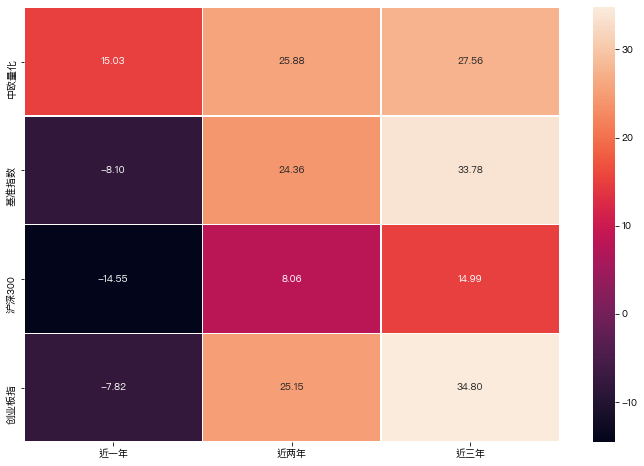

In [77]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(return_df, linewidths=.5, annot=True, fmt=".2f")

In [78]:
fund_value

,index,净值日期,单位净值,日增长率,year,month
0,0,2018-05-16,1.0000,0.00,2018,5
1,1,2018-05-18,1.0002,0.00,2018,5
2,2,2018-05-25,1.0003,0.00,2018,5
3,3,2018-06-01,0.9999,0.00,2018,6
4,4,2018-06-08,1.0008,0.00,2018,6
...,...,...,...,...,...,...
882,882,2022-01-17,1.8288,1.50,2022,1
883,883,2022-01-18,1.8300,0.07,2022,1
884,884,2022-01-19,1.8140,-0.87,2022,1
885,885,2022-01-20,1.7867,-1.50,2022,1


In [118]:
monthly_return_df = pd.DataFrame(index=range(2018,2023),columns=range(1,13))

for year in year_list:
    month_list = fund_value[fund_value['year'] == year]['month'].unique()
    for month in month_list:
        df = fund_value[(fund_value['year'] == year) & (fund_value['month'] == month)]
        ret = (df['单位净值'].values[-1]/df['单位净值'].values[0] - 1) * 100
        monthly_return_df.loc[year, month] = ret

monthly_return_df = monthly_return_df.fillna(0.00)

Text(88.0, 0.5, 'Year')

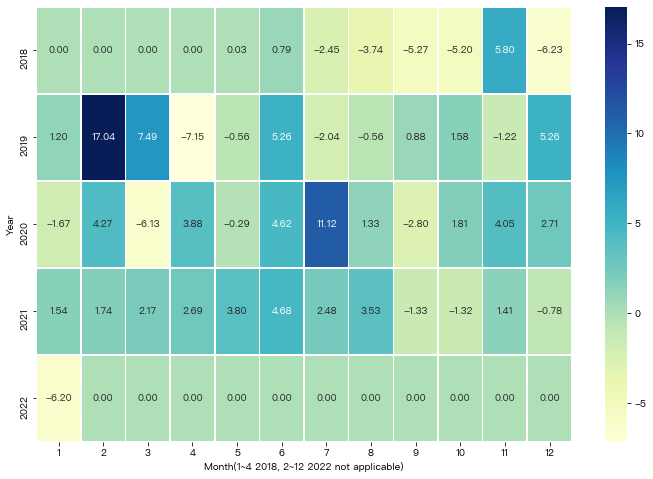

In [124]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(monthly_return_df, linewidths=.5, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Month(1~4 2018, 2~12 2022 not applicable)')
plt.ylabel('Year')

<BarContainer object of 45 artists>

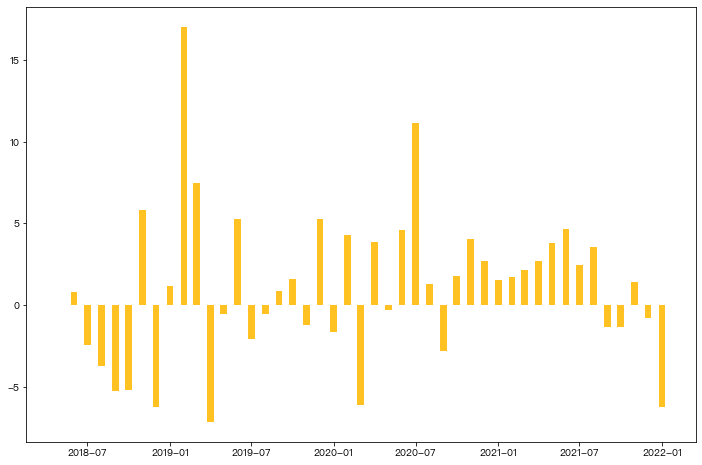

In [253]:
return_bar_df = pd.DataFrame()
return_list = []
for year in year_list:
    month_list = fund_value[fund_value['year'] == year]['month'].unique()
    for month in month_list:
        df = fund_value[(fund_value['year'] == year) & (fund_value['month'] == month)]
        timestamp = pd.to_datetime(str(year)+'-'+str(month))
        return_list.append((df['单位净值'].values[-1]/df['单位净值'].values[0] - 1) * 100)
        return_bar_df[timestamp] = 0

return_bar_df = return_bar_df.T
return_bar_df['ret'] = return_list


fig = plt.figure(figsize=(12,8))
plt.bar(return_bar_df.index, return_bar_df['ret'], width=15, color='#FFC222')
        

In [254]:
## highest return 5 months
## not hard to see the highest returns fall on 2019 Feb, 2020 Jul, 2019 Mar, 2018 Nov, 2019 Jun


## calculate the return without the highest return one by one

losing_index = return_bar_df.sort_values('ret', ascending=False).head().index

ret_result = []
for index in losing_index:
    return_bar_df.loc[index, 'ret'] = 0
    ret_array = return_bar_df.ret/100 + 1
    ret_result.append((np.prod(ret_array) - 1)*100)

ret_result = [comp_stat_df.iloc[0,0]*100] + ret_result
ret_result

[76.42,
 32.01393165985351,
 18.801968923679226,
 10.526239931988979,
 4.463565547495008,
 -0.7611494107497951]

Text(0.5, 1.0, '错过最高收益累计收益率-衰减比例')

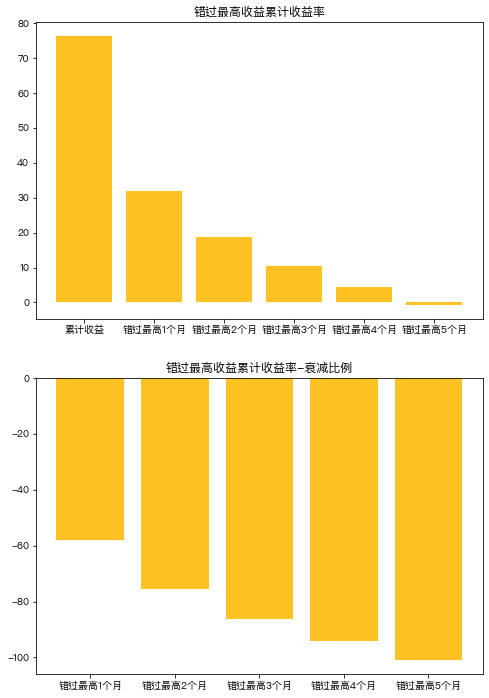

In [273]:
losing_profit_df = pd.DataFrame(index=['累计收益', '错过最高1个月', '错过最高2个月', '错过最高3个月', '错过最高4个月', '错过最高5个月'])

losing_profit_df['收益率'] = ret_result
decay_ratio = (np.array(ret_result[1:])/ret_result[0]-1)*100
decay_profit_df = pd.DataFrame(index=['错过最高1个月', '错过最高2个月', '错过最高3个月', '错过最高4个月', '错过最高5个月'], columns=['收益率'], data=decay_ratio)

fig = plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.bar(losing_profit_df.index, losing_profit_df['收益率'], color='#FFC222')
plt.title('错过最高收益累计收益率')
plt.subplot(2,1,2)
plt.bar(decay_profit_df.index, decay_profit_df['收益率'], color='#FFC222')
plt.title('错过最高收益累计收益率-衰减比例')

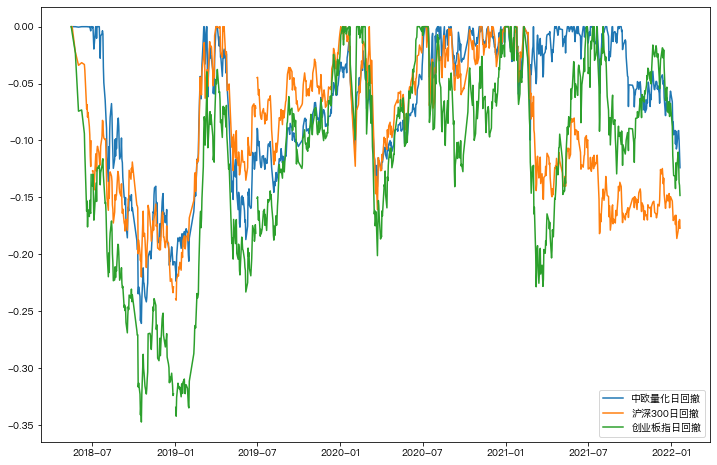

In [307]:
## drawdown analysis

# fund_value = fund_value.set_index('净值日期')
# HS300_df = HS300_df.set_index('净值日期')
# CYZH_df = CYZH_df.set_index('净值日期')

fig = plt.figure(figsize=(12,8))

plt.plot(max_drawdown_df(fund_value, PLOT=False), label='中欧量化日回撤')
plt.plot(max_drawdown_df(HS300_df, PLOT=False), label='沪深300日回撤')
plt.plot(max_drawdown_df(CYZH_df, PLOT=False), label='创业板指日回撤')
plt.legend()
plt.title('回撤深水线')

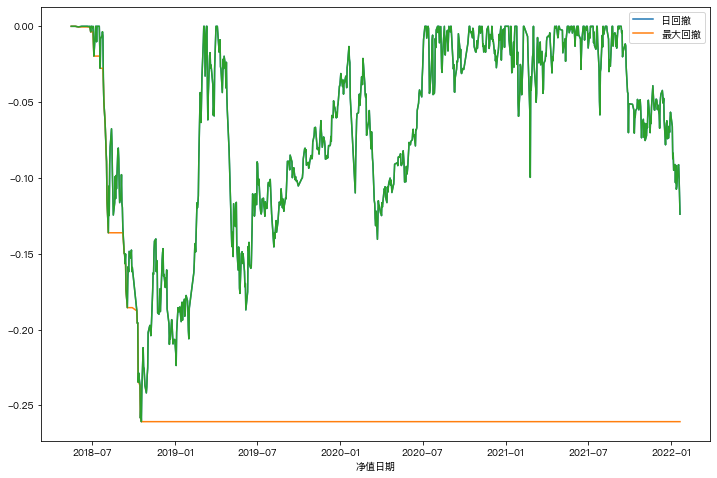

In [311]:
max_drawdown_df(fund_value, PLOT=True).plot()

In [336]:
def fixing_timing(df):

    roll_max = df['单位净值'].rolling(len(df), 1).max()
    daliy_drawdown = df['单位净值'] / roll_max - 1.0
    max_daily_drawdown = daliy_drawdown.rolling(len(df), 1).min().round(5)

    return max_daily_drawdown

In [316]:
drawdown_list = np.unique(fixing_timing(fund_value).values)

fixing_timing(fund_value).values.round(5)

for value in fixing_timing(fund_value).values:
    df = pd.DataFrame(fixing_timing(fund_value))
    sub_df = df[df['单位净值'] == value]

array([-0.26079171, -0.25843544, -0.23704053, -0.23477851, -0.19585297,
       -0.18774741, -0.18557964, -0.1737983 , -0.15655042, -0.15042413,
       -0.14976437, -0.13619227, -0.11442036, -0.08934967, -0.08199811,
       -0.07426956, -0.06465598, -0.04919887, -0.03553252, -0.02770971,
       -0.01964091, -0.01111001, -0.00368526, -0.00169323, -0.00039988,
        0.        ])

In [331]:
drawdown_list = np.unique(fixing_timing(fund_value).values)
drawdown_list

array([-0.26079, -0.25844, -0.23704, -0.23478, -0.19585, -0.18775,
       -0.18558, -0.1738 , -0.15655, -0.15042, -0.14976, -0.13619,
       -0.11442, -0.08935, -0.082  , -0.07427, -0.06466, -0.0492 ,
       -0.03553, -0.02771, -0.01964, -0.01111, -0.00369, -0.00169,
       -0.0004 ,  0.     ])

In [341]:
df = pd.DataFrame(fixing_timing(fund_value).round(5))
df[df['单位净值'] == -0.0000]

,单位净值
净值日期,
2018-05-16,0.0
2018-05-18,0.0
2018-05-25,0.0
2018-06-08,0.0
2018-06-14,0.0
...,...
2021-09-06,0.0
2021-09-07,0.0
2021-09-09,0.0


#### Fund Performance Attribution(against factor models)

In [429]:
import statsmodels.api as sm

capm_df = pd.read_csv('./factor data/CAPM单因子模型.csv').round(6)
ff3f_df = pd.read_csv('./factor data/Fama-French-三因子模型.csv').round(6)
ff5f_df = pd.read_csv('./factor data/Fama-French-五因子模型.csv').round(6)
carhart4_df = pd.read_csv('./factor data/Carhart-四因子模型.csv').round(6)

capm_df['date'] = pd.to_datetime(capm_df['date'])
ff3f_df['date'] = pd.to_datetime(ff3f_df['date'])
ff5f_df['date'] = pd.to_datetime(ff5f_df['date'])
carhart4_df['date'] = pd.to_datetime(carhart4_df['date'])

In [430]:
capm_df

,date,RF,MKT
0,1995-01-03,0.000182,-0.009724
1,1995-01-04,0.000182,0.023004
2,1995-01-05,0.000182,-0.009166
3,1995-01-06,0.000182,-0.007825
4,1995-01-09,0.000182,-0.027512
...,...,...,...
6553,2021-12-27,0.000069,0.000316
6554,2021-12-28,0.000069,0.005397
6555,2021-12-29,0.000069,-0.008921
6556,2021-12-30,0.000069,0.007040


In [431]:
## slice factor data to fit the fund period

start_date = pd.to_datetime('2018-05-16')
end_date = pd.to_datetime('2021-12-31')

mask =  (capm_df["date"] >= start_date) & (capm_df["date"] <= end_date)
capm_df = capm_df.loc[mask].set_index('date').dropna()
mask =  (ff3f_df["date"] >= start_date) & (ff3f_df["date"] <= end_date)
ff3f_df = ff3f_df.loc[mask].set_index('date').dropna()
mask =  (ff5f_df["date"] >= start_date) & (ff5f_df["date"] <= end_date)
ff5f_df = ff5f_df.loc[mask].set_index('date').dropna()
mask =  (carhart4_df["date"] >= start_date) & (carhart4_df["date"] <= end_date)
carhart4_df = carhart4_df.loc[mask].set_index('date').dropna()


In [432]:
fund_value = get_fund_net_worth('001980', start_date=start_date, end_date=end_date, fund_category='open')[['净值日期','单位净值']].set_index('净值日期')
fund_value['ret'] = (fund_value['单位净值']/fund_value['单位净值'].shift())-1
fund_value.dropna(inplace=True)

capm_perform_attr = fund_value.join(capm_df).dropna()
ff3f_perform_attr = fund_value.join(ff3f_df).dropna()
ff5f_perform_attr = fund_value.join(ff5f_df).dropna()
carhart4_perform_attr = fund_value.join(carhart4_df).dropna()

In [453]:
Fund_Perform_Attribution(capm_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1135.
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          1.14e-242
Time:                        16:26:50   Log-Likelihood:                 3093.2
No. Observations:                 869   AIC:                            -6180.
Df Residuals:                     866   BIC:                            -6166.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.365      0.1

In [454]:
Fund_Perform_Attribution(ff3f_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     612.3
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          2.12e-250
Time:                        16:26:56   Log-Likelihood:                 3118.2
No. Observations:                 869   AIC:                            -6226.
Df Residuals:                     864   BIC:                            -6203.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.001     -1.820      0.0

In [455]:
Fund_Perform_Attribution(ff5f_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     434.4
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          1.36e-256
Time:                        16:27:03   Log-Likelihood:                 3139.1
No. Observations:                 869   AIC:                            -6264.
Df Residuals:                     862   BIC:                            -6231.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.976      0.0

In [456]:
Fund_Perform_Attribution(carhart4_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     494.4
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          2.07e-250
Time:                        16:27:07   Log-Likelihood:                 3121.5
No. Observations:                 869   AIC:                            -6231.
Df Residuals:                     863   BIC:                            -6202.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.896      0.0